# Rice Leaf Diseases: Deep Learning and Transfer Learning (Part 1)
This notebook will continue our exploration of the [Rice Leaf Diseases dataset from Kaggle](https://www.kaggle.com/vbookshelf/rice-leaf-diseases).

## Setting up your environment
Before running this notebook, you will need to make sure you have [downloaded](https://www.kaggle.com/vbookshelf/rice-leaf-diseases) the dataset and extracted the files.  This notebook assumes the image data is extracted in the same directory as this notebook, and that the top-level data directory is named "rice_leaf_diseases".  You can edit the code if those assumptions do not hold on your own setup.

## Python environment
You will need the following packages installed to execute the code shown in this notebook:

* [Matplotlib](https://matplotlib.org/)
* [Numpy](https://numpy.org/)
* [Pandas](https://pandas.pydata.org/)
* [Pillow](https://pillow.readthedocs.io/en/stable/)
* [Scikit-Learn](https://scikit-learn.org/)
* [Tensorflow](https://www.tensorflow.org/)

## Local directory structure
This notebook assumes you have the rice leaf images in the following directory structure:

    rice_leaf_diseases/
        Bacterial leaf blight/
        Brown spot/
        Leaf smut/

The "ground truth" file "_rice_leaf_diseases_ground_truth.csv_" was created in the previous ("rice_image_EDA") notebook.  If you don't have this file, you can create it by running the first several cells in that notebook, which is available [by clicking here](https://gist.github.com/jcausey-astate/207ba4d65126abe0482b740b41117f9e).

In [1]:
import sys, os
import tensorflow as tf, tensorflow.keras as keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import sklearn.metrics as metrics

We want to train a deep learning CNN-based model that should be capable of looking at the images of rice leaves and focusing on features that will allow the model to discriminate between the different types of disease.  

To train such a model from scratch would require a large amount of computational time and (ideally) thousands of training images.   The Kaggle dataset only has ~120 images, split into three classes (about 40 per class), so we cannot hope to train a cutting-edge model from scratch.

To overcome this hurdle, we will make use of the fact that many of the "features" we see in natural images are common across images of different classes of "things" - color, shape, texture, etc.  We will use a model that has already been trained on a different natural image dataset, and we will simply replace the layers responsible for performing the classification task.  The already-trained parameters for the rest of the model will perform feature extraction for our new classifier, which we will have to train.  Using features learned on a similar (but different) dataset to simplify application of a machine learning model on a new dataset is called *transfer learning*, and it is an important tool for researchers.

First, let's load up the ground truth data we created in the previos ("rice_image_EDA") notebook.  If you don't have this file, you can create it by running the first several cells in that notebook, which is available [by clicking here](https://gist.github.com/jcausey-astate/207ba4d65126abe0482b740b41117f9e).

In [2]:
ground_truth_df = pd.read_csv("rice_leaf_diseases_ground_truth.csv")
ground_truth_df.head()

,class,image_path
0,leaf_blight,rice_leaf_diseases/Bacterial leaf blight/DSC_0...
1,leaf_blight,rice_leaf_diseases/Bacterial leaf blight/DSC_0...
2,leaf_blight,rice_leaf_diseases/Bacterial leaf blight/DSC_0...
3,leaf_blight,rice_leaf_diseases/Bacterial leaf blight/DSC_0...
4,leaf_blight,rice_leaf_diseases/Bacterial leaf blight/DSC_0...


Just like we did in the EDA notebook previously, we will split the data into a training and testing set using  `StratifiedShuffleSplit` from Scikit-Learn.  It will randomize the data and make sure the test set's class distribution approximately matches the training set.  We will use an 80% (train) / 20% (test) split.

In [3]:
sss = StratifiedShuffleSplit(1, test_size=0.20, random_state=2021)
train_indices, test_indices = list(sss.split(ground_truth_df.values, ground_truth_df['class'].values))[0]
print(f"Training set has {train_indices.shape[0]} samples.")
print(f"Test set has {test_indices.shape[0]} samples.")

Training set has 96 samples.
Test set has 24 samples.


## Creating the model

Now, let's create the model.  We will use the Xception model, which is available in [Keras Applications](https://keras.io/api/applications/xception/).  This model provides a nice tradeoff between overall number of parameters and accuracy, with a reasonable default input image size ($299 \times 299$ pixels).

Because we will be using transfer learning, we will initialize the model with pre-trained weights that were trained on the ImageNet dataset.  ImageNet is a large dataset of natural images, so it should provide a good base model for transfer learning to our leaf images.

In [4]:
xception_base = keras.applications.Xception(
    include_top = False, 
    weights="imagenet", 
    input_shape=(299,299,3), 
    classes=3
)

The `include_top = False` argument specifies that we do not want the classification layer from the original model (this is often referred to as the "head" or "top" of a deep learning model).  The `weights` parameter specifies the pre-trained weights we want (we are using ImageNet).  We explicitly set the `input_shape` to specify we will use $299 \times 299$ pixel images, with 3 color channels.  Finally, the `classes` parameter is set to 3 to reflect our three rice diseases: Leaf blight, Brown spot, and Leaf smut.

We can see the structure of the model by using its `summary()` method.  To see this, just un-comment the following line of code (it is commented here because the output is lengthy).  We can see that the model has around 20 million trainable parameters.

In [5]:
# xception_base.summary()

### Adding a custom classification layer

Since we set `include_top` to `False` when we created the model, our model does not have a classifer layer...  We will add that now.

We will also set the base model's parameters to be non-trainable so that the training process will not try to modify them.  This is common in transfer learning -- if we allowed the base model's parameters to be trained, we would make its performance _worse_ because it would receive loss feedback from the new layer we are about to add that will be randomly initialized (and thus not very good at predicting the class at first).  By locking the base weights as non-trainable, we protect them while we allow the new layer's weights to train in isolation.  This is the "trick" that allows transfer learning to be so effective - we are training only a fraction of the total parameters in the model.

In [6]:
xception_base.trainable = False # mark the base model as non-trainable to prevent changing the pre-trained weights.and

leaf_classifier_input  = keras.layers.Input(shape=(299,299,3))
# We will pass the inputs to the base model, and mark it's `training` parameter as False so that it is running
# in "inference" mode.  See (https://keras.io/guides/transfer_learning/) for details.
intermediate_values = xception_base(leaf_classifier_input, training=False)
# We need to reshape the features from the base model (which are 4-dimensional CNN outputs) into a vector that
# can easily be fed into a fully-connected ("Dense") layer.  We will do this by using a `GlobalAveragePooling2D`
# layer which will average the values produced by each of the filters (CNN outputs) into single values, giving
# us a vector.
intermediate_values = keras.layers.GlobalAveragePooling2D()(intermediate_values)
# Now we will attach the output layer so that it receives the intermediate features from Xception:
leaf_classifier_output = keras.layers.Dense(3, activation="softmax")(intermediate_values)
leaf_classifier_model = keras.Model(inputs=leaf_classifier_input, outputs=leaf_classifier_output)

If you un-comment the line below and look at the summary, you'll see that there are just over 6,000
trainable parameters now (about .003% of the total parameters for the model).  

We should be able to
train those even with our small training set (96 images).  In fact, we will start to overfit very quickly, so we will only use a small number of epochs for now.

In [7]:
# leaf_classifier_model.summary()

## Create a generator to handle loading the images

Now we need to set up the training dataset so that we can pass it to a model for training.  There is more than one way to do this... The most obvious way is just to read the images using the `PIL` library like we did in the EDA notebook.  This has a couple of drawbacks though:

1. We would be loading the entire training dataset into memory at once.  Our dataset is small, so this probably isn't a problem - but for larger training sets it could exhaust the machine's memory.
2. Our images are not all the same size.  If you examine the image data, you will see that they come in a range of sizes and aspect ratios.  The mean dimensions are about $2362 \times 717$ pixels, but there is quite a lot of variation.  The model we will be using for our first transfer learning experiment (Xception) was designed to support images of shape $299 \times 299$.  We _can_ change that to make it larger, but it will be costly in terms of memory use (both on our computer and on the GPU when we start training).  For now, let's choose to rescale the images to make them fit in $299 \times 299$ pixels.

The good news is that the Keras framework includes several nice tools to help with loading image datasets for training and testing.  They have already tackled both of these issues.  By using an object called a "generator", we will allow Keras to load only enough images at a time to keep the model training without delay, but without loading all of them at once.  Keras can also take care of resizing the images automatically (and in a "smart" way to assure that we keep the aspect ratio while padding to make the image the correct size).

The object we will use for this purpose is the [`ImageDataGenerator`](https://keras.io/api/preprocessing/image/#imagedatagenerator-class) class from the [`tf.keras.preprocessing`](https://keras.io/api/preprocessing) library.  It has a method called [`flow_from_dataframe()`](https://keras.io/api/preprocessing/image/#flowfromdataframe-method) that will do exactly what we need, since our ground truth is already in a Pandas DataFrame.

The `ImageDataGenerator` can also help us perform some simple data augmentation, but we will look at that later.


In [8]:
# Declare the generator (we will take default initial paramters for now)
train_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0
)
train_dataflow = train_generator.flow_from_dataframe(
    ground_truth_df.iloc[train_indices,:],
    x_col = "image_path",
    y_col = "class",
    target_size = (299,299),
    seed = 2021
)
image_classes = sorted(train_dataflow.class_indices.keys())

Found 96 validated image filenames belonging to 3 classes.


## Let's train

Now we can start to train the model on the rows of the dataframe that were selected as part of the training set (the indices are stored in `train_indices`).  

First we call `compile()` to initialize the (trainable) weights of the new model, and to set up the parameters for the optimization process.  Then we will call the `fit()` method and use the `iloc[]` accessor for the ground truth DataFrame to create a filtered DataFrame containing only these training rows, and use the `flow_from_dataframe()` method of our `ImageDataGenerator` object to feed the training images to the training process.

One note:  We need to use the `rescale` parameter to specify that values stored for each pixel must be rescaled.  When we load the images, the color of each pixel is determined by a set of three numbers (one per color channel: red, green, and blue).  These numbers are integers in the range $[0,255]$ when we load the images.

But, the Xception model (and most models that take images as input) requires that the values be floating-point values in the range $[0,1]$.  To accomplish this, we scale each value (for each channel) by dividing it by 255, so that we get a value in $[0,1]$.  This is done by passing the scaling value $\frac{1}{255}$ to the `rescale` parameter.

In [9]:
# We will set the seeds for both the Tensorflow and Numpy random number generators so that we get repeatable 
# results from the training process.  If you change the seed value, the results will be different.
tf.random.set_seed(2021)
np.random.seed(2021)
leaf_classifier_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
)
leaf_classifier_model.fit(
    train_dataflow,
    epochs=5
)

Epoch 1/5
3/3 [==============================] - 8s 2s/step - loss: 1.1551 - categorical_accuracy: 0.2812
Epoch 2/5
3/3 [==============================] - 6s 2s/step - loss: 0.9794 - categorical_accuracy: 0.6146
Epoch 3/5
3/3 [==============================] - 6s 2s/step - loss: 0.8356 - categorical_accuracy: 0.7812
Epoch 4/5
3/3 [==============================] - 6s 2s/step - loss: 0.7289 - categorical_accuracy: 0.8542
Epoch 5/5
3/3 [==============================] - 6s 2s/step - loss: 0.6375 - categorical_accuracy: 0.8958


## Time to predict

Let's see how we did...  Just like in the EDA notebook, we will run inferrence on the 20% of images we set aside for the test set, then look at the performance by category.  We can use another `ImageDataGenerator` to do this - this one will feed from the testing indices of our ground truth, and it won't bother shuffling the order of the images.

In [10]:
test_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0
)
test_dataflow = test_generator.flow_from_dataframe(
    ground_truth_df.iloc[test_indices,:],
    x_col = "image_path",
    y_col = "class",
    target_size = (299,299),
    shuffle = False
)
predictions = leaf_classifier_model.predict(test_dataflow)

Found 24 validated image filenames belonging to 3 classes.


Now, we have the predictions.  We use a _confusion matrix_ to compare the predicted label versus the correct label for all classes.  The number of correct predictions are shown along the diagonal; all other numbers are counting incorrect predictions.  

In the EDA notebook we use the Scikit_learn `plot_confusion_matrix()` function, but we saw that it takes the model, inputs, and labels as parameters.  It then makes the predictions internally and compares them.  This will not work in our case because the model we just trained actually predicts an analog to the _probability_ for each class for _every_ value.  So, we need to use the predictions we just made to assign a class label to the most highly probably class.

We can do this very easily by using the Numpy `argmax()` function to find the _index_ of the _column_ whose value is highest, and do that for each row that was predicted.  We use the `axis=1` parameter to specify we want the _column_ index for every row.  The result will be a vector of values in ${0,1,2}$.

In [11]:
predicted_classes = list(np.argmax(predictions, axis=1))
print(predicted_classes)

[2, 0, 2, 1, 2, 1, 1, 1, 2, 2, 1, 0, 1, 2, 0, 1, 2, 1, 2, 1, 0, 1, 0, 1]


These predictions correspond to our three classes in the order we specified them when training/predicting:

    0: 'leaf_blight'
    1: 'brown_spot'
    2: 'leaf_smut'

Let's create a numeric representation for the ground truth as well:

In [12]:
class_to_int = test_dataflow.class_indices
gt_classes = test_dataflow.classes
print(gt_classes)

[2, 2, 2, 1, 0, 1, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 2, 1, 2, 1, 0, 0, 2, 0]


Now we can get our confusion matrix, although we have to do it a bit differently.   We create a `ConfusionMatrixDisplay` object given the confusion matrix computed by the SciKit Learn metrics `confusion_matrix()` function, then tell it to `plot()` itself:

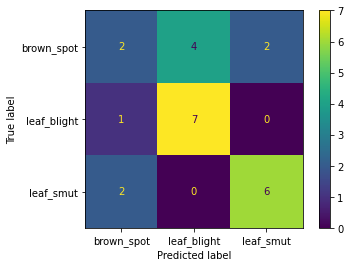

In [13]:
metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(gt_classes, predicted_classes), 
    display_labels=image_classes
).plot()

Let's also show the classification report:

In [14]:
print(metrics.classification_report(gt_classes, predicted_classes, target_names=image_classes))

              precision    recall  f1-score   support

  brown_spot       0.40      0.25      0.31         8
 leaf_blight       0.64      0.88      0.74         8
   leaf_smut       0.75      0.75      0.75         8

    accuracy                           0.62        24
   macro avg       0.60      0.62      0.60        24
weighted avg       0.60      0.62      0.60        24



## Summing it up and thinking about what's next

These results are better than the histogram-based model we used in the EDA notebook, but they still aren't outstanding...  We have plenty of room for improvement.

Look around at techniques that might be able to improve the performance of the model.  Some things to consider:

* We only trained for 5 epochs because overfitting could be an issue if we trained longer.  Look for ways to mitigate overfitting.
* We used the `GlobalAveragePooling` layer to connect the Xception base model to our new classification layer.  This led to only ~6,000 trainable parameters.  Using a `Flatten` layer instead would have given us about 600,000 parameters!  The downside is that all those additional parameters could make the overfitting issue even worse.
* Xception is only one of several pre-trained models available from the Keras Applications library - we could try others.  Take a look, and notice how the parameter counts vary between different models there.